In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
import itertools

In [3]:
from Variables import *
from LoadFunctions import *
from ThreeDWindRadarFunctions import *
from MatchFunctions import *
from OtherUsefulFunctions import *
from Paths_workstation import *
import matlab.engine

In [4]:
startDate = dt.datetime(2020,6,19)
endDate = dt.datetime(2020,8,18)
dateList = produceDateList(startDate,endDate)

# Scatter Plot

In [5]:
from scipy.constants import golden 
matplotlib.rcParams['figure.figsize'] = (golden * 10, 10)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fontsize1 = 22
matplotlib.rcParams.update({'font.size': fontsize1})

In [7]:
reCreate=False

In [8]:
if os.path.exists(os.getcwd()+'/ListsFixed/ALLfixed.pickle') and (reCreate is False):
    with open(os.getcwd()+'/ListsFixed/ALLfixed.pickle', "rb") as f:
        Dic = pickle.load(f)
        
else:
    Dic = defaultdict(list)
    for chosenDate in dateList:

        if os.path.exists(os.getcwd()+'/ListsFixed/'+chosenDate+"fixedCoherency.pickle"):
            with open(os.getcwd()+'/ListsFixed/'+chosenDate+"fixedCoherency.pickle", "rb") as f:
                CoherencyFixed = pickle.load(f)

            for beam_number in range(2,6):
                for kk in range(0,len(CoherencyFixed[str(beam_number)+'RadarRadialV'])):
                    Dic[str(beam_number)+'RadarRadialV'].append(CoherencyFixed[str(beam_number)+'RadarRadialV'][kk])
                    Dic[str(beam_number)+'LidarRadialV'].append(CoherencyFixed[str(beam_number)+'LidarRadialV'][kk])
                    Dic[str(beam_number)+'Start'].append(CoherencyFixed[str(beam_number)+'Start'][kk])
                    Dic[str(beam_number)+'End'].append(CoherencyFixed[str(beam_number)+'End'][kk])   

    with open(os.getcwd()+'/ListsFixed/ALLfixed.pickle', "wb") as f:
        pickle.dump(Dic, f)

/home/mco/.pyenv/versions/3.6.9/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/home/mco/.pyenv/versions/3.6.9/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/home/mco/.pyenv/versions/3.6.9/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  

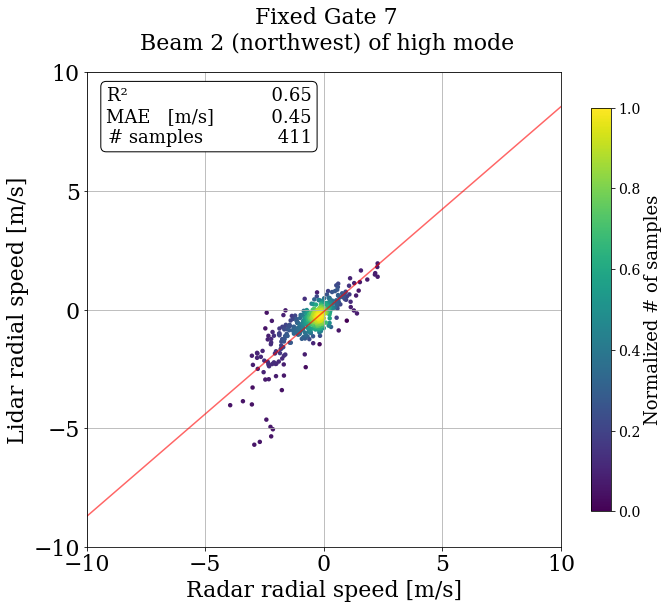

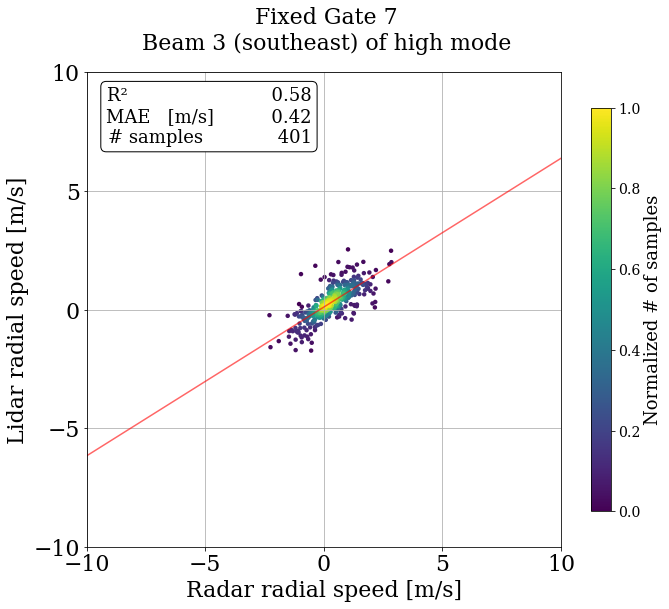

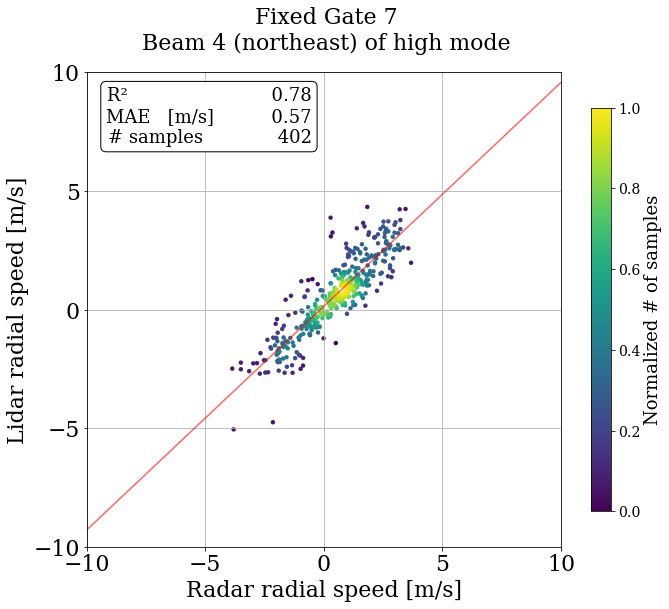

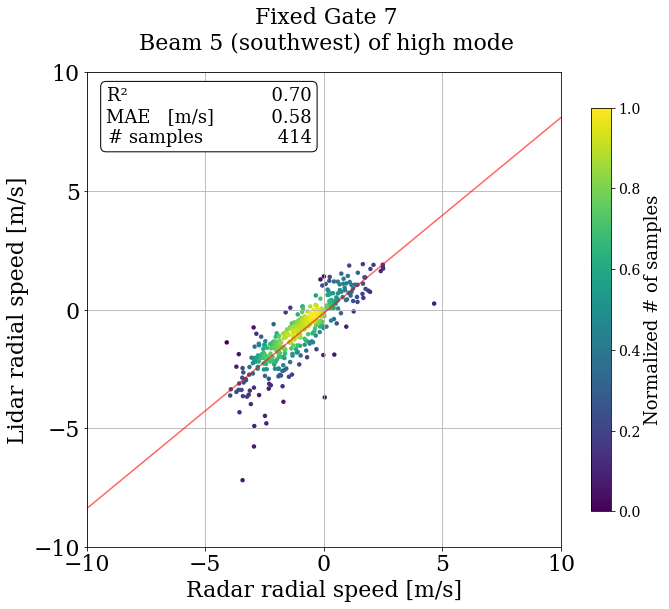

In [9]:
option='fast'

for beam_number in range(2,6):
    
    newRadar=[];newLidar=[]
    for indice,k in enumerate(Dic[str(beam_number)+'RadarRadialV']):
        newRadar.append(k[[[7]]])
        newLidar.append(Dic[str(beam_number)+'LidarRadialV'][indice][[7]])
    x, y = reshapeList(newRadar, newLidar)
    #x, y = reshapeList(Dic[str(beam_number)+'RadarRadialV'], Dic[str(beam_number)+'LidarRadialV'])
    
    
    score1, coef1, inter1, sum1, mae1, std1, mask,slope,intercept,MAE, RMSE, SUM, SCORE= doRegression(x,y)
    x=x[mask];y=y[mask];
    #results[beam_number].append([MAE, RMSE, SUM, SCORE])
    
    if option == 'fast':
        data, x_e, y_e = np.histogram2d(x,y,bins=[12,12])
        z = scipy.interpolate.interpn((0.5*(x_e[1:]+x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])),
                                       data,np.vstack([x,y]).T, method="splinef2d", bounds_error=False)
    if option == 'best':
        xy = np.vstack([x,y])
        z = scipy.stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x,y,z = x[idx],y[idx],z[idx]

    fig, ax = plt.subplots()
    xx = np.arange(-10, 11, 1)
    ax.plot(xx, slope*xx+intercept, 'red', alpha=0.6)

    ax.annotate("Fixed Gate 7\n{}".format(beam_radar_pretty[str(beam_number)]),
    xy=(240, 540), xycoords='axes points', #550
    size=fontsize1, ha='center', va='top')
    ax.annotate("R\u00b2 {: >28}\nMAE   [m/s]{: >14}\n# samples {: >15}".format(score1,mae1, sum1),
    xy=(225, 460), xycoords='axes points',
    size=fontsize1-4, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))

    cax=ax.scatter(x,y, c=z/100000, s=20, edgecolor='')
    ax.set_xlabel('Radar radial speed [m/s]',fontsize=fontsize1);
    ax.set_ylabel('Lidar radial speed [m/s]',fontsize=fontsize1);
    ax.grid()    
    plt.gca().set_aspect('equal')
    plt.gcf().set_size_inches(10,10)
    ax.set_xlim([-10, 10]); ax.set_ylim([-10, 10])
    ax.set_xticks(np.arange(-10,11,5)); ax.set_yticks(np.arange(-10,11,5))

    norm = matplotlib.colors.Normalize(0,1)
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm),ax=ax, shrink=0.65)
    cbar.ax.set_ylabel('Normalized # of samples', rotation=90, fontsize=fontsize1-4)
    cbar.ax.tick_params(labelsize=14)

    plt.tight_layout()
    plt.savefig(pathSave+'coherency_fixedGate7_'+str(beam_number))

# Produce lists fixed

In [ ]:
reCreate=False

In [ ]:
for chosenDate in dateList:

    # Radar Files
    folder_radar=sorted(glob.glob(str(path_dat)+chosenDate+'.DAT/'))
    filepaths_radar = [sorted(glob.glob(k+'*.dat')) for k in folder_radar]
    filepaths_radar= functools.reduce(operator.iconcat, filepaths_radar, [])
    filenames_radar =[os.path.basename(k) for k in filepaths_radar]
    date_radar = [correct_hour(k[:-4]) for k in filenames_radar]
    date_radardt = [dt.datetime.strptime('20'+k[:5]+k[5:-2].zfill(2)+k[-2:], '%Y%m%d%H%M') for k in date_radar]
    _, filepaths_radarFULL,_,_,_,_= loadRadar(chosenDate, path_dat, verbose=False)

    ###############################

    #Lidar Files
    folder_lidar=sorted(glob.glob(str(path_lidar)+chosenDate+'/wind_and_aerosols_data/*/'), 
                                  key=lambda x:int(re.search("(/\d{1,2}-)", x).group(1)[1:-1]))     
    filepaths_lidar = [sorted(glob.glob(str(k)+'WLS*fixed*.nc')) for k in folder_lidar]
    filepaths_lidar = functools.reduce(operator.iconcat, filepaths_lidar, [])
    filenames_lidar=[os.path.basename(k) for k in filepaths_lidar]
    date_lidar=[re.search("([0-9]{4}\-[0-9]{2}\-[0-9]{2}_[0-9]{2}\-[0-9]{2}\-[0-9]{2})", k).group(1) 
                     for k in filenames_lidar]  
    date_lidardt = [dt.datetime.strptime(k, '%Y-%m-%d_%H-%M-%S') for k in date_lidar]

    ###############################

    if len(filepaths_radar)>0:
        
        radarStart, radarEnd = radarStartEnd(chosenDate, filepaths_radar, reCreate=False)

        ###############################
        # Load radial fixed for lidar
        ###############################
        if os.path.exists(os.getcwd()+'/ListsFixed/fixedLidar'+chosenDate+".pickle") and (reCreate is False):
            with open(os.getcwd()+'/ListsFixed/'+chosenDate+"fixedLidar.pickle", "rb") as f:
                lidarEnd = pickle.load(f)
        else:
            lidarEnd = defaultdict(list); timestampFixed=0;

            for indice,k in enumerate(filepaths_lidar):
                group_name = list(netCDF4.Dataset(k).groups.keys())[1]
                sw = xr.open_dataset(k, group=group_name,decode_times=False)
                sw.radial_wind_speed_status.values[sw.radial_wind_speed_status.values == 0] = np.nan
                if 'fixed_19' in k: beam_numberLidar=0
                if 'fixed_21' in k: beam_numberLidar=1
                if 'fixed_22' in k: beam_numberLidar=2
                if 'fixed_23' in k: beam_numberLidar=3

                for indiceTime, kTime in enumerate(sw.timestamp.values):
                    radialV=sw.radial_wind_speed.values[indiceTime]*sw.radial_wind_speed_status.values[indiceTime]
                    try:
                        endTime = dt.datetime.strptime(kTime, "%Y-%m-%dT%H:%M:%S.%fZ") 
                        lidarEnd[beam_numberLidar].append(endTime)
                    except ValueError:
                        endTime = dt.datetime.strptime(kTime[:3]+'0-0'+kTime[3:], "%Y-%m-%dT%H:%M:%SZ") 
                        timestampFixed+=1
                        lidarEnd[beam_numberLidar].append(endTime)
                    lidarEnd[str(beam_numberLidar)+'radialV'].append(radialV)  
            #print('Fixed timestamps ', timestampFixed)

            with open(os.getcwd()+'/ListsFixed/'+chosenDate+"fixedLidar.pickle", "wb") as f:
                pickle.dump(lidarEnd, f) 

        ###############################
        # Match with radar
        ###############################

        if os.path.exists(os.getcwd()+'/ListsFixed/'+chosenDate+"fixedCoherency.pickle") and (reCreate is False):
            with open(os.getcwd()+'/ListsFixed/'+chosenDate+"fixedCoherency.pickle", "rb") as f:
                CoherencyFixed = pickle.load(f)

        else:
            eng = matlab.engine.start_matlab()
            eng.addpath(os.getcwd()+'/MatlabFunctions/',nargout=0)
            CoherencyFixed = defaultdict(list)

            for beam_numberLidar in range(0,4):
                beam_numberRadar=lidar2radar[beam_numberLidar]

                for indiceRadar, kRadar in enumerate(radarStart[beam_numberRadar]):
                    chosenDay = dt.datetime.strptime(padChosenDate(chosenDate), '%Y%m%d').day
                    RadarStart = kRadar
                    RadarEnd = radarEnd[beam_numberRadar][indiceRadar]
                    if (RadarStart.minute <=7) & (RadarEnd.minute<=8) & (RadarStart.day==chosenDay) & (RadarEnd.day==chosenDay): #& (RadarStart.hour==0)
                        # Mask lidar data by radar
                        mask = (pd.Series(lidarEnd[beam_numberLidar])<RadarEnd) & (pd.Series(lidarEnd[beam_numberLidar])>RadarStart)
                        indiceTrue = mask[mask].index.values
                        # Load Radar
                        out = eng.loadMoments(filepaths_radarFULL[indiceRadar], beam_numberRadar,nargout=5)
                        RadarRadialV = np.array(out[0])

                        if len(indiceTrue)>0:
                            #print(RadarStart, RadarEnd)
                            # Interpolate
                            rangeLidar = sw.range.values
                            target = high_mode-490
                            # Almost the same to average before or after interpolation, verified (difference 10⁻3)
                            if len(indiceTrue)>1:
                                radial = np.nanmean(lidarEnd[str(beam_numberLidar)+'radialV'][indiceTrue[0]:indiceTrue[-1]], axis=0)
                            elif len(indiceTrue)==1:
                                radial = lidarEnd[str(beam_numberLidar)+'radialV'][indiceTrue[0]]
                            LidarRadialV = np.interp(target, rangeLidar, radial)
                            # Find closest moment
                            result = MatchClosestMoment(LidarRadialV, RadarRadialV)
                            CoherencyFixed[str(beam_numberRadar)+'RadarRadialV'].append(f2vRadar(result))
                            CoherencyFixed[str(beam_numberRadar)+'LidarRadialV'].append(LidarRadialV)
                            CoherencyFixed[str(beam_numberRadar)+'Start'].append(RadarStart)
                            CoherencyFixed[str(beam_numberRadar)+'End'].append(RadarEnd) 
                        #else:
                        #    print('Empty sequence : ', kRadar)
            with open(os.getcwd()+'/ListsFixed/'+chosenDate+"fixedCoherency.pickle", "wb") as f:
                pickle.dump(CoherencyFixed, f)
                
        print(chosenDate + ' finished')
                
    else:
        print(chosenDate, ' empty')
            